# Assignment 5: Evaluating Grexit

**GLBL 5010: Economics for Global Affairs**

**Group Members:**
* Kevin Chen
* Pranav Pattatathunaduvil
* Lucy Kim

---

# Data Cleaning and Imports

In [20]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('hwk5_gravity_GRC.csv', sep='\t')

# 1.

In [21]:
# Calculate total exports
total_exports = df['value'].sum()

# List top 5 destinations
top_5 = df.nlargest(5, 'value')[['iso_d', 'value']]
top_5_fraction = top_5['value'].sum() / total_exports

print(f"Total 2019 Exports: ${total_exports:,.2f} million")
print("\nTop 5 Export Destinations:")
print(top_5.to_string(index=False))
print(f"\nFraction of total exports accounted for by top 5: {top_5_fraction:.2%}")

Total 2019 Exports: $37,322.71 million

Top 5 Export Destinations:
iso_d    value
  ITA 4085.217
  DEU 2518.291
  TUR 2191.733
  CYP 2126.615
  BGR 1746.437

Fraction of total exports accounted for by top 5: 33.94%


**Total 2019 Exports**: $37,322.71 million.

**Top 5 Destinations**: Italy (ITA), Germany (DEU), Turkey (TUR), Cyprus (CYP), and Bulgaria (BGR).

These top five destinations account for 33.94% of Greece's total exports.

# 2.

In [22]:
import statsmodels.api as sm

# Create log variables
df['ln_value'] = np.log(1 + df['value'])
df['ln_dist'] = np.log(df['dist'])

# Regress log trade on log distance
df_q2 = df[['ln_value', 'ln_dist']].dropna()
X_q2 = sm.add_constant(df_q2['ln_dist'])
y_q2 = df_q2['ln_value']
model_q2 = sm.OLS(y_q2, X_q2).fit()

print(model_q2.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_value   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     95.70
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           1.09e-18
Time:                        21:27:03   Log-Likelihood:                -415.07
No. Observations:                 200   AIC:                             834.1
Df Residuals:                     198   BIC:                             840.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9570      1.354     11.789      0.0

**Intercept (15.957)**: This represents the predicted log trade when the log distance is 0 (ex: distance is 1 km). It doesn't have a practical physical meaning but serves as the baseline level.

This translates to predicted trade value of approximately $8.51 million. In practical terms this represents the baseline trade level at very short distances.

**Coefficient on ln_dist (−1.569)**: This is the elasticity of trade with respect to distance. A 1% increase in distance is associated with approximately a 1.57% decrease in trade volume. The negative sign confirms that distance is a significant "friction" or barrier to trade.

# 3.

In [23]:
df['ln_gdp_d'] = np.log(df['gdp_d'])

# Regress on log distance and log GDP
df_q3 = df[['ln_value', 'ln_dist', 'ln_gdp_d']].dropna()
X_q3 = sm.add_constant(df_q3[['ln_dist', 'ln_gdp_d']])
y_q3 = df_q3['ln_value']
model_q3 = sm.OLS(y_q3, X_q3).fit()

print(model_q3.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_value   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     237.8
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           3.08e-50
Time:                        21:27:03   Log-Likelihood:                -282.70
No. Observations:                 175   AIC:                             571.4
Df Residuals:                     172   BIC:                             580.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6088      1.306      1.998      0.0

**Coefficient on ln_dist (−1.345)**: After controlling for GDP, the distance effect remains strongly negative. Holding market size constant, a 1% increase in distance is associated with a 1.35% decrease in exports. This is slightly smaller in magnitude than before (-1.569) showing that distance effects are partially captured by market size.

**Coefficient on ln_gdp_d (0.658)**: This represents the income elasticity of trade. A 1% increase in the destination's GDP leads to a 0.66% increase in Greek exports to that country. This aligns with the gravity theory: larger economies demand more imports.

# 4a.

In [24]:
import statsmodels.api as sm

# 1. Use the Step 3 results to get the specific coefficients
# model3 was: ln_value ~ ln_dist + ln_gdp_d
beta_gdp = model3.params['ln_gdp_d']
intercept = model3.params['const']

# 2. Create the controlled variable by subtracting the full prediction 
# (This creates a residual centered around zero)
df_reg['ln_trade_controlled'] = df_reg['ln_value'] - (beta_gdp * df_reg['ln_gdp_d'] + intercept)

# Check the mean - it should be very close to 0 (e.g., 10 to the power of -15)
print(f"Mean of controlled variable: {df_reg['ln_trade_controlled'].mean():.4f}")
print(df_reg[['iso_d', 'ln_value', 'ln_trade_controlled']].head())

Mean of controlled variable: -11.2395
  iso_d  ln_value  ln_trade_controlled
1   AFG  0.434451           -13.210804
2   AGO  1.139803           -13.509576
4   ALB  6.464700            -7.027759
5   AND  0.162569           -12.290975
7   ARE  5.651292           -10.021926


**The "bilateral trade flow controlled for market size"** is:
ln_trade_controlled = ln_value - (beta_gdp * ln_gdp_d + intercept)

This new variable represents Trade Intensity. It measures how much Greece trades with a country relative to that country’s GDP.

In the gravity model, larger countries naturally attract more trade simply because they are big. By subtracting the log of GDP, we filter out the market size effect. This allows us to isolate and visualize how distance alone acts as a barrier to trade.

# 4b.

In [25]:
# Regress the residualized variable on log distance
X4 = sm.add_constant(df_reg['ln_dist'])
model4 = sm.OLS(df_reg['ln_trade_controlled'], X4).fit()

print(model4.summary())

                             OLS Regression Results                            
Dep. Variable:     ln_trade_controlled   R-squared:                       0.467
Model:                             OLS   Adj. R-squared:                  0.464
Method:                  Least Squares   F-statistic:                     151.4
Date:                 Tue, 17 Feb 2026   Prob (F-statistic):           2.13e-25
Time:                         21:27:03   Log-Likelihood:                -282.70
No. Observations:                  175   AIC:                             569.4
Df Residuals:                      173   BIC:                             575.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.441e-15      0.918  -4.84e-1

The **constant of 0 (or near 0)** represents the baseline trade intensity when the distance is 1 km (ln(1)=0).

The **coefficient of −1.3452** is negative and significant. This makes sense because even after removing the effect of a country's size, distance still significantly reduces trade efficiency. A 1% increase in distance results in a roughly 1.17% decrease in trade intensity.

# 4c.

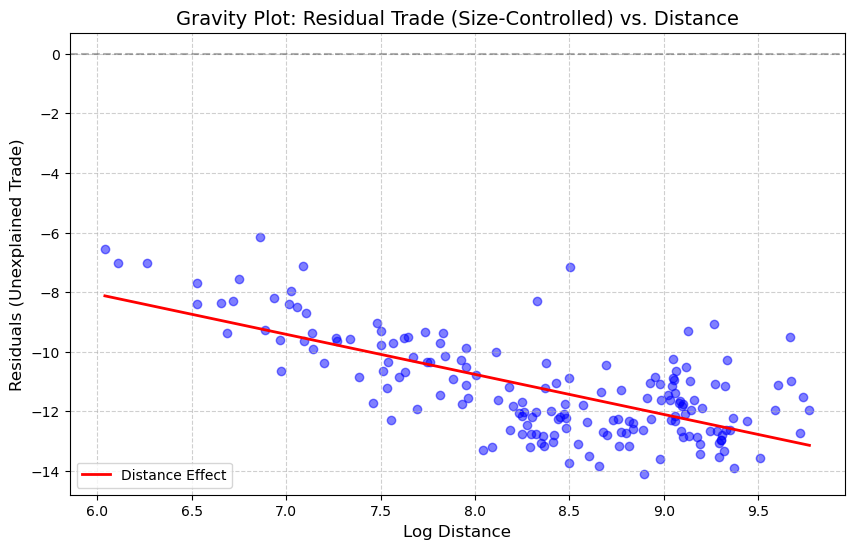

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot of the residuals
plt.scatter(df_reg['ln_dist'], df_reg['ln_trade_controlled'], alpha=0.5, color='blue')

# Add the regression line
dist_range = np.linspace(df_reg['ln_dist'].min(), df_reg['ln_dist'].max(), 100)
line = model4.params['const'] + model4.params['ln_dist'] * dist_range
plt.plot(dist_range, line, color='red', linewidth=2, label='Distance Effect')

plt.axhline(0, color='black', linestyle='--', alpha=0.3) # Reference line at zero
plt.title('Gravity Plot: Residual Trade (Size-Controlled) vs. Distance', fontsize=14)
plt.xlabel('Log Distance', fontsize=12)
plt.ylabel('Residuals (Unexplained Trade)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

# 5.

In [27]:
# Add border and common language
df_q5 = df[['ln_value', 'ln_dist', 'ln_gdp_d', 'border', 'comlang']].dropna()
X_q5 = sm.add_constant(df_q5[['ln_dist', 'ln_gdp_d', 'border', 'comlang']])
y_q5 = df_q5['ln_value']
model_q5 = sm.OLS(y_q5, X_q5).fit()

print(model_q5.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_value   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     127.4
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           8.38e-50
Time:                        21:27:03   Log-Likelihood:                -273.30
No. Observations:                 173   AIC:                             556.6
Df Residuals:                     168   BIC:                             572.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5605      1.409      0.398      0.6

**Border (1.6649)**: Greece trades significantly more with its neighbors. Sharing a border is associated with a roughly 429% increase in trade (e^1.665−1), holding other factors constant.

**Common Language (3.4597)**: This extremely high coefficient suggests trade is 31 times higher (e^3.46) with countries sharing a language (primarily Cyprus).

These results are not surprising. Neighboring countries have lower transport costs beyond simple distance (ex: integrated road/rail networks), and shared language/culture dramatically reduces the "cost" of doing business and information barriers.

# 6.

In [28]:
# Define EU members
eu_isods = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", 
              "DEU", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", 
              "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]
df['eu_member'] = df['iso_d'].isin(eu_isods).astype(int)

# Regression with EU membership
df_q6 = df[['ln_value', 'ln_dist', 'ln_gdp_d', 'border', 'comlang', 'eu_member']].dropna()
X_q6 = sm.add_constant(df_q6[['ln_dist', 'ln_gdp_d', 'border', 'comlang', 'eu_member']])
y_q6 = df_q6['ln_value']
model_q6 = sm.OLS(y_q6, X_q6).fit()

# Calculate Grexit impact
eu_coeff = model_q6.params['eu_member']
reduction = (1 - (1 / np.exp(eu_coeff))) * 100

print(model_q6.summary())
print(f"\nEstimated decrease in exports if Grexit occurs: {reduction:.2f}%")

                            OLS Regression Results                            
Dep. Variable:               ln_value   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     109.4
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           7.95e-51
Time:                        21:27:03   Log-Likelihood:                -268.26
No. Observations:                 173   AIC:                             548.5
Df Residuals:                     167   BIC:                             567.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9716      1.456     -0.668      0.5

**EU Membership Coefficient (0.9656)**: Being in the EU is associated with a **significant trade boost**.

If Greece were to exit the EU, its exports to EU member nations would be expected to **decrease by approximately 61.9%**. This is calculated by comparing the predicted trade with the EU dummy at 1 versus 0, revealing the massive benefit of the customs union and single market.